In [1]:
import os
print(os.listdir('../data/train/'))

['sunflower', 'rose', 'tulip']


In [2]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
 
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
%pip install tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
 
import tensorflow as tf
import random as rn

# Install tqdm if not already installed
%pip install tqdm

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image

Note: you may need to restart the kernel to use updated packages.


2025-08-06 07:22:35.934538: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-06 07:22:36.022383: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-06 07:22:36.662720: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-06 07:22:39.499270: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Note: you may need to restart the kernel to use updated packages.


In [3]:
X=[]
Z=[]
IMG_SIZE=150
FLOWER_SUNFLOWER_DIR='../data/train/sunflower'
FLOWER_TULIP_DIR='../data/train/tulip'
FLOWER_ROSE_DIR='../data/train/rose'

In [4]:
def assign_label(img,flower_type):
    return flower_type
    

In [5]:
def make_train_data(flower_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assign_label(img,flower_type)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        
        X.append(np.array(img))
        Z.append(str(label))

In [6]:
make_train_data('Sunflower',FLOWER_SUNFLOWER_DIR)
print(len(X))

100%|██████████| 758/758 [00:03<00:00, 193.32it/s]

758


In [7]:
make_train_data('Tulip',FLOWER_TULIP_DIR)
print(len(X))

100%|██████████| 1009/1009 [00:04<00:00, 250.81it/s]

1767


In [8]:
def make_train_data_safe(flower_type, DIR):
	for img in tqdm(os.listdir(DIR)):
		label = assign_label(img, flower_type)
		path = os.path.join(DIR, img)
		img_array = cv2.imread(path, cv2.IMREAD_COLOR)
		if img_array is not None:
			img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
			X.append(np.array(img_array))
			Z.append(str(label))
		else:
			print(f"Warning: Unable to read image {path}")

make_train_data_safe('Rose', FLOWER_ROSE_DIR)
print(len(X))

 71%|███████   | 574/810 [00:02<00:00, 289.73it/s]

100%|██████████| 810/810 [00:03<00:00, 244.20it/s]

2576


2.2 ) Visualizing some Random Images

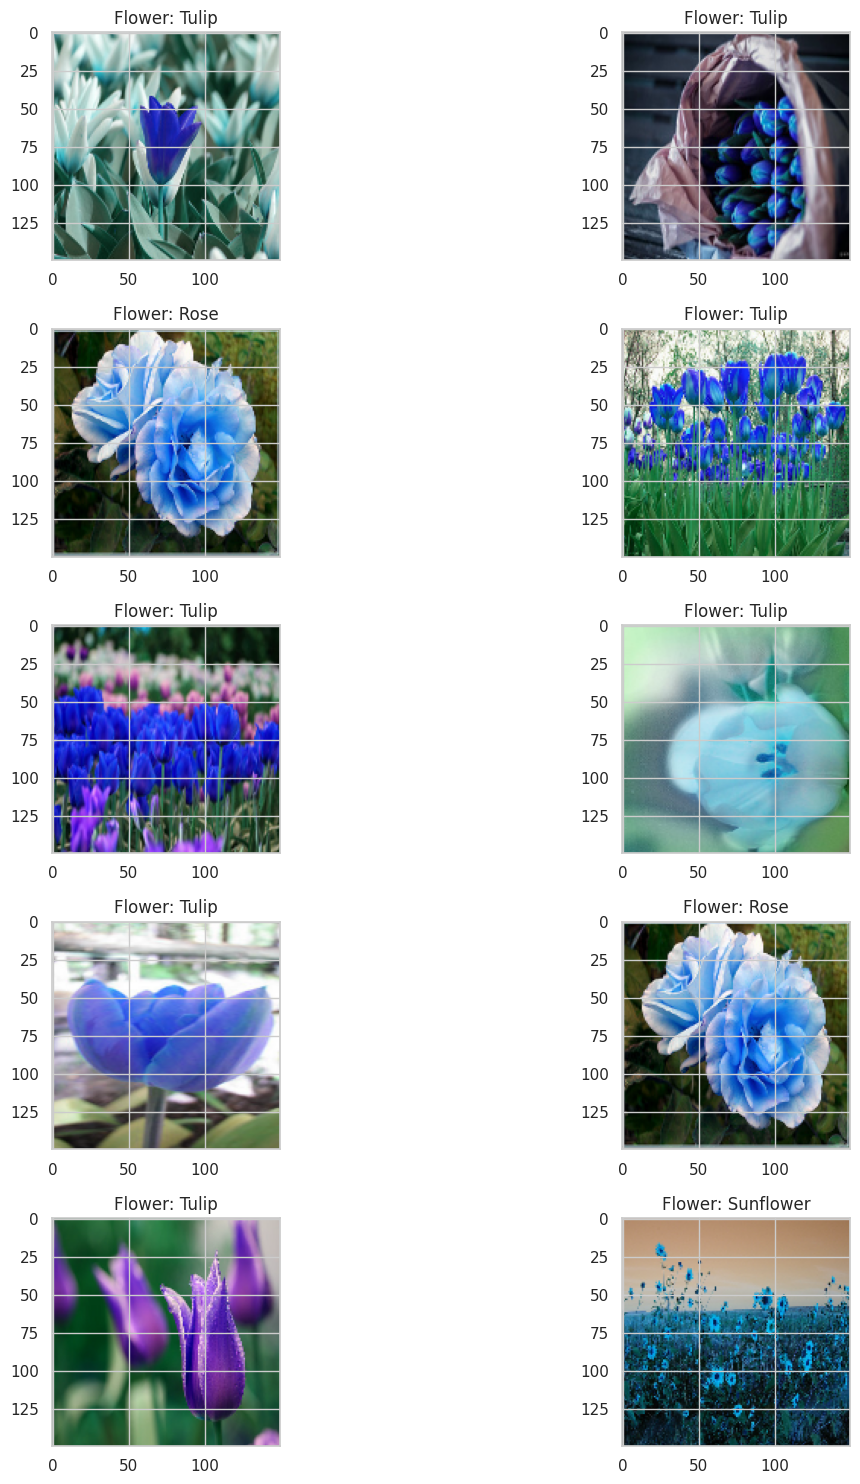

In [9]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Flower: '+Z[l])
        
plt.tight_layout()
        

2.3 ) Label Encoding the Y array

In [10]:
le=LabelEncoder()
Y=le.fit_transform(Z)
Y=to_categorical(Y,3)
X=np.array(X)
X=X/255

## 2.4 ) Splitting into Training and Validation Sets

In [11]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=42)

## 2.5 ) Setting the Random Seeds

In [12]:
np.random.seed(42)
rn.seed(42)
tf.random.set_seed(42)

## 3 ) Modelling

## 3.1 ) Building the ConvNet Model

In [13]:
# # modelling starts using a CNN.

model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (150,150,3)))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
 

model.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(3, activation = "softmax"))

## 3.2 ) Using a LR Annealer

In [14]:
batch_size=128
epochs=50

from keras.callbacks import ReduceLROnPlateau
red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)

## 3.3 ) Data Augmentation to prevent Overfitting

In [15]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

## 3.4 ) Compiling the Keras Model & Summary

In [16]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 96)     │        55,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 96)     │        83,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 7776)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     3,981,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,142,723 (15.80 MB)

 Trainable params: 4,142,723 (15.80 MB)

 Non-trainable params: 0 (0.00 B)

## 3.5 ) Fitting on the Training set and making predcitons on the Validation set

In [18]:
History = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                    epochs=epochs, validation_data=(x_test, y_test),
                    verbose=1, steps_per_epoch=x_train.shape[0] // batch_size)
# model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test))

Epoch 1/50


2025-08-06 07:25:08.489141: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 34560000 exceeds 10% of free system memory.
2025-08-06 07:25:08.530886: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 368640000 exceeds 10% of free system memory.
2025-08-06 07:25:09.473384: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 92160000 exceeds 10% of free system memory.
2025-08-06 07:25:09.642168: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 184320000 exceeds 10% of free system memory.
2025-08-06 07:25:10.359897: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 44859392 exceeds 10% of free system memory.


15/15 ━━━━━━━━━━━━━━━━━━━━ 119s 7s/step - accuracy: 0.4606 - loss: 1.0787 - val_accuracy: 0.5807 - val_loss: 0.8091
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 555ms/step - accuracy: 0.5625 - loss: 0.7873 - val_accuracy: 0.6118 - val_loss: 0.7938
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 96s 6s/step - accuracy: 0.5909 - loss: 0.8017 - val_accuracy: 0.5963 - val_loss: 0.8589
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 526ms/step - accuracy: 0.6406 - loss: 0.8728 - val_accuracy: 0.6211 - val_loss: 0.8302
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 96s 6s/step - accuracy: 0.6186 - loss: 0.7718 - val_accuracy: 0.6584 - val_loss: 0.7279
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 534ms/step - accuracy: 0.6406 - loss: 0.7058 - val_accuracy: 0.6817 - val_loss: 0.7233
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 95s 6s/step - accuracy: 0.6458 - loss: 0.7161 - val_accuracy: 0.7050 - val_loss: 0.6724
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 510ms/step - accuracy: 0.6797 - loss: 0.7158 - val_accuracy: 0.7096 - val_los

In [19]:

# Save the model in HDF5 format
model.save("../models/flower_cnn_model.h5")
print("✅ Model saved successfully to 'models/flower_cnn_model.h5'")

✅ Model saved successfully to 'models/flower_cnn_model.h5'


## 4 ) Evaluating the Model Performance

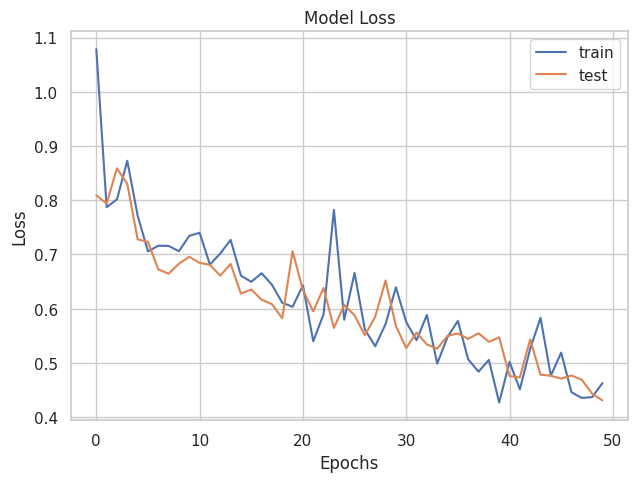

In [20]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

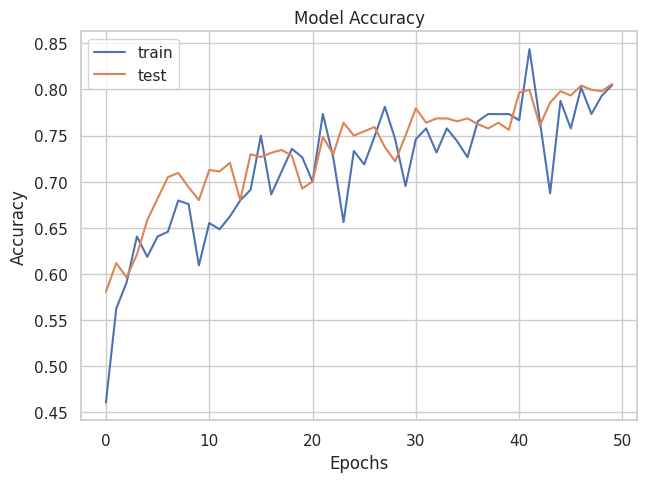

In [21]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()


## 5 ) Visualizing Predictons on the Validation Set

In [22]:
# getting predictions on val set.
pred=model.predict(x_test)
pred_digits=np.argmax(pred,axis=1)

21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 381ms/step


In [23]:
# now storing some properly as well as misclassified indexes'.
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test)):
    if(np.argmax(y_test[i])==pred_digits[i]):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(y_test)):
    if(not np.argmax(y_test[i])==pred_digits[i]):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

#### CORRECTLY CLASSIFIED FLOWER IMAGES

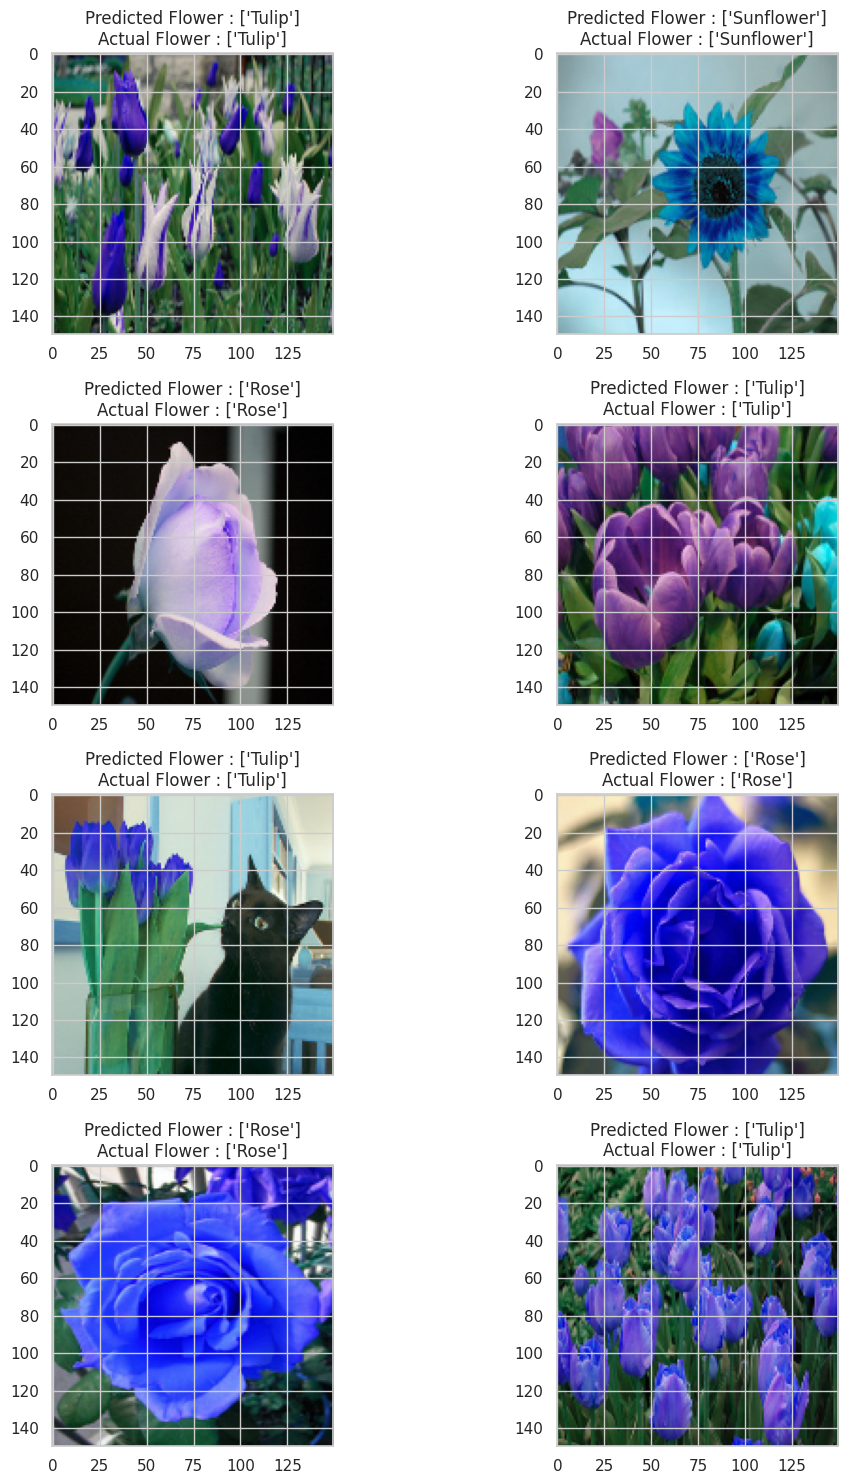

In [24]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[prop_class[count]])
        ax[i,j].set_title(
            "Predicted Flower : " + str(le.inverse_transform([pred_digits[prop_class[count]]])) + "\n" +
            "Actual Flower : " + str(le.inverse_transform([np.argmax(y_test[prop_class[count]])]))
        )
        plt.tight_layout()
        count+=1

#### MISCLASSIFIED IMAGES OF FLOWERS

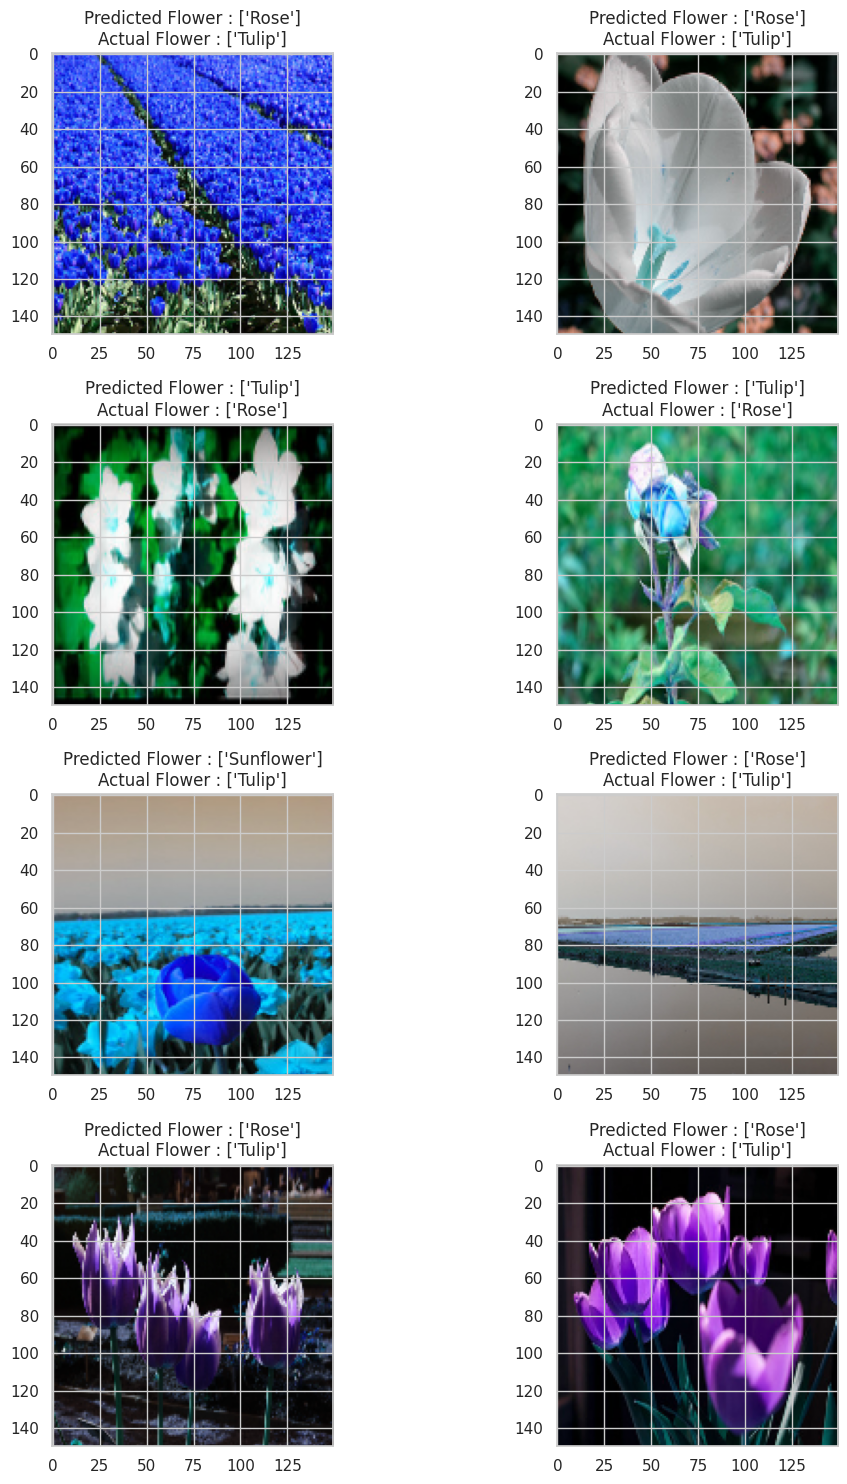

In [25]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[mis_class[count]])
        ax[i,j].set_title(
            "Predicted Flower : " + str(le.inverse_transform([pred_digits[mis_class[count]]])) + "\n" +
            "Actual Flower : " + str(le.inverse_transform([np.argmax(y_test[mis_class[count]])]))
        )
        plt.tight_layout()
        count+=1